### From Paper to Code: Understanding and Reproducing "Denoising Diffusion Probabilistic Models"
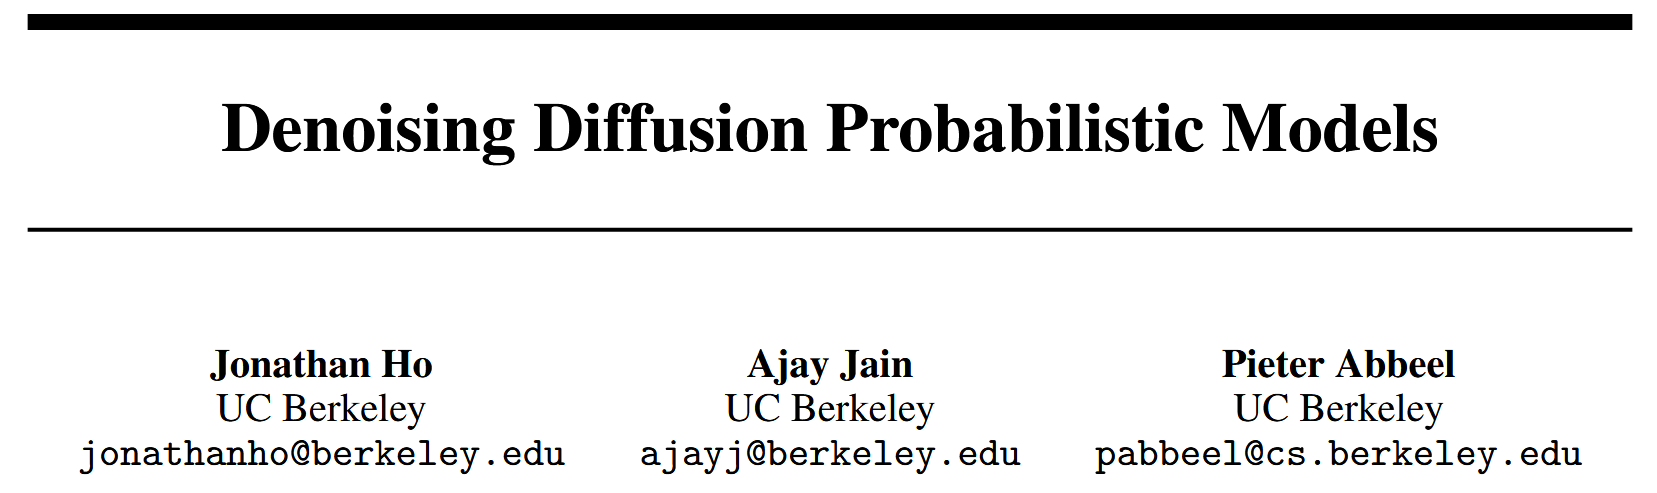
Code: [GitHub Repository](https://github.com/lucidrains/denoising-diffusion-pytorch), 
Corresponding code: ../../../../code/Inv/denoising-diffusion-pytorch-main/demo.py

# Paper Reading Notes

## Background

In recent years, deep generative models have achieved impressive results in generating realistic data. Models such as Generative Adversarial Networks (GANs) [1], Variational Autoencoders (VAEs) [2], and Normalizing Flows [3] have been widely adopted in image, audio, and text synthesis. However, these methods often face various trade-offs between sample quality, likelihood estimation, and training stability.

Diffusion Probabilistic Models (DPMs), introduced by Sohl-Dickstein et al. [4], offer a conceptually simple alternative. A DPM gradually corrupts data with Gaussian noise and then learns to reverse this process using a neural network. While theoretically elegant, early diffusion models were not competitive in sample quality.
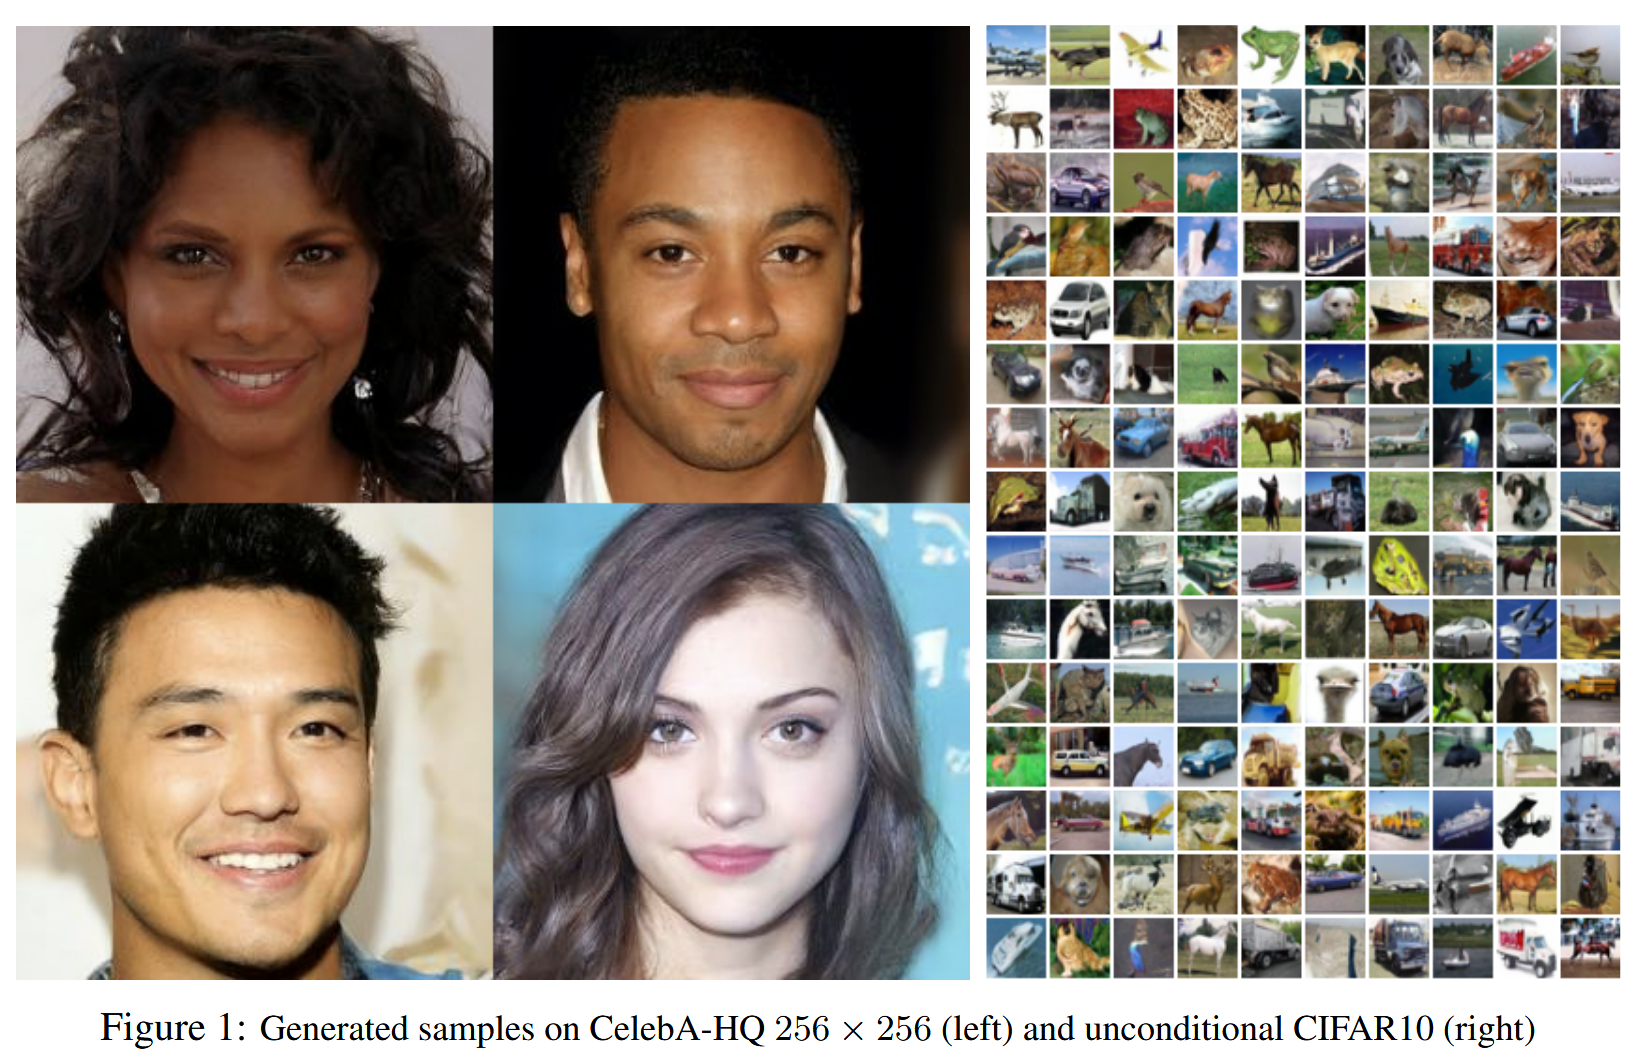

## Method Overview

This paper by Ho et al. (2020) [5] proposes a new formulation of diffusion probabilistic models that significantly improves their generation quality. The model consists of two processes:

### 1. Forward Process (Diffusion) 
The forward process gradually adds Gaussian noise to the original data $x_0$, forming a sequence $x_1, x_2, \dots, x_T$:

$$
q(x_{1:T} | x_0) := \prod_{t=1}^T q(x_t | x_{t-1}), \quad q(x_t | x_{t-1}) = \mathcal{N}(\sqrt{1 - \beta_t}x_{t-1}, \beta_t I)
$$

This simulates the data being slowly destroyed by noise.

It also allows sampling directly from any step $t$ given the original $x_0$:

$$
q(x_t | x_0) = \mathcal{N}(\sqrt{\bar{\alpha}_t}x_0, (1 - \bar{\alpha}_t)I)
$$

We define the accumulated product of noise schedule as:

$$
\bar{\alpha}_t = \prod_{s=1}^t (1 - \beta_s)
$$ 
The forward process gradually adds Gaussian noise to the original data $x_0$, forming a sequence of increasingly noisy images $x_1, x_2, \dots, x_T$.

This is defined as a fixed Markov process:

$$
q(x_{1:T} | x_0) := \prod_{t=1}^T q(x_t | x_{t-1}), \quad q(x_t | x_{t-1}) = \mathcal{N}(\sqrt{1 - \beta_t}x_{t-1}, \beta_t I)
$$

Using a closed-form derivation, we can sample $x_t$ directly from $x_0$ without simulating all intermediate steps:

$$
q(x_t | x_0) = \mathcal{N}(\sqrt{\bar{\alpha}_t}x_0, (1 - \bar{\alpha}_t)I)
$$

where the cumulative noise scale is:

$$
\bar{\alpha}_t = \prod_{s=1}^t (1 - \beta_s)
$$

This means we can generate a noisy version of the image at any timestep $t$ using:

$$
x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, I)
$$



### 🔧 Code: `q_sample` Implementation

The following function implements the equation above in PyTorch:

In [1]:
def q_sample(self, x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(self.sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

`q_sample` directly corresponds to the equation:

$$
x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \varepsilon
$$

- `x_start` is $x_0$, the original clean image.
- `t` is the timestep.
- `noise` is sampled from $\mathcal{N}(0, I)$ if not provided.
- `self.sqrt_alphas_cumprod[t]` is precomputed $\sqrt{\bar{\alpha}_t}$.
- `self.sqrt_one_minus_alphas_cumprod[t]` is precomputed $\sqrt{1 - \bar{\alpha}_t}$.
- `extract(...)` applies the appropriate scalar to every image in the batch.

This function is used during training to corrupt the original image and teach the model how to denoise it.

<!-- ### 2. Reverse Process (Denoising)

The reverse process is trained to undo the diffusion:

$$
p_\theta(x_{0:T}) := p(x_T) \prod_{t=1}^T p_\theta(x_{t-1} | x_t), \quad p_\theta(x_{t-1} | x_t) = \mathcal{N}(\mu_\theta(x_t, t), \Sigma_\theta(x_t, t))
$$

Instead of predicting $\mu_\theta$ directly, the authors propose to predict the noise $\varepsilon$ that was added in the forward process.

Using this trick, the training loss becomes:

$$
L_{\text{simple}}(\theta) = \mathbb{E}_{t,x_0,\varepsilon} \left[ \left\| \varepsilon - \varepsilon_\theta\left(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\varepsilon, t\right) \right\|^2 \right]
$$

This resembles denoising score matching and simplifies training using standard stochastic gradient descent. -->

### 2. Reverse Process (Denoising)

The reverse process is trained to undo the diffusion:

$$
p_\theta(x_{0:T}) := p(x_T) \prod_{t=1}^T p_\theta(x_{t-1} | x_t), \quad p_\theta(x_{t-1} | x_t) = \mathcal{N}(\mu_\theta(x_t, t), \Sigma_\theta(x_t, t))
$$

Instead of predicting $\mu_\theta$ directly, the authors propose to predict the noise $\varepsilon$ that was added in the forward process.

Using this trick, the training loss becomes:

$$
L_{\text{simple}}(\theta) = \mathbb{E}_{t,x_0,\varepsilon} \left[ \left\| \varepsilon - \varepsilon_\theta\left(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\varepsilon, t\right) \right\|^2 \right]
$$

This resembles denoising score matching and simplifies training using standard stochastic gradient descent.



### 🧪 Code: `forward()` and `p_losses()` for Training

In [ ]:
def forward(self, img, *args, kwargs):
    b, c, h, w, device, img_size = *img.shape, img.device, self.image_size
    assert h == img_size[0] and w == img_size[1]
    t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

    img = self.normalize(img)
    return self.p_losses(img, t, *args, kwargs)

- Sample random timestep $t$.
- Normalize $x_0$ to $[-1, 1]$.
- Compute loss using p_losses().

In [3]:
def p_losses(self, x_start, t, noise=None, offset_noise_strength=None):
    noise = default(noise, lambda: torch.randn_like(x_start))

    if offset_noise_strength := default(offset_noise_strength, self.offset_noise_strength) > 0.:
        offset_noise = torch.randn(x_start.shape[:2], device=self.device)
        noise += offset_noise_strength * rearrange(offset_noise, 'b c -> b c 1 1')

    x = self.q_sample(x_start=x_start, t=t, noise=noise)

    x_self_cond = None
    if self.self_condition and random() < 0.5:
        with torch.no_grad():
            x_self_cond = self.model_predictions(x, t).pred_x_start
            x_self_cond.detach_()

    model_out = self.model(x, t, x_self_cond)

    if self.objective == 'pred_noise':
        target = noise
    elif self.objective == 'pred_x0':
        target = x_start
    elif self.objective == 'pred_v':
        v = self.predict_v(x_start, t, noise)
        target = v
    else:
        raise ValueError(f'unknown objective {self.objective}')

    loss = F.mse_loss(model_out, target, reduction='none')
    loss = reduce(loss, 'b ... -> b', 'mean')
    loss = loss * extract(self.loss_weight, t, loss.shape)
    return loss.mean()

- Add noise to $x_0$ to get $x_t$.
- Predict $\varepsilon$ (or $x_0$, or $v$) from $x_t$ using the network.
- Compute MSE loss between prediction and target.
- Weight loss by timestep and return the average.

This is a direct implementation of the loss:

$$
\left\| \varepsilon - \varepsilon_\theta\left(x_t, t\right) \right\|^2
$$

where $x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \varepsilon$.
```

## Contributions

The main contributions of this paper are:

1. Noise Prediction Parameterization: Instead of predicting the denoised image, the model predicts the noise added during diffusion, making training more stable and effective.

2. Simplified Training Objective: The authors propose a training loss that is simple to implement and closely related to denoising score matching.

3. High-Quality Image Synthesis: The model achieves state-of-the-art results on datasets like CIFAR-10 and LSUN, outperforming many GAN-based models.

4. Progressive Sampling Interpretation: The sampling process can be viewed as a form of progressive decoding, providing a new perspective on how diffusion models generate data.


## References

[1] Goodfellow et al., 2014. *Generative Adversarial Networks (GANs)*  
[2] Kingma and Welling, 2013. *Auto-Encoding Variational Bayes*  
[3] Dinh et al., 2016. *Real NVP*  
[4] Sohl-Dickstein et al., 2015. *Deep Unsupervised Learning using Nonequilibrium Thermodynamics*  
[5] Ho et al., 2020. *Denoising Diffusion Probabilistic Models*


# Demo

In [4]:
import os
import sys
print("Current working directory:", os.getcwd())
target_path = os.path.abspath(os.path.join(os.getcwd(), "../../../code/Inv/denoising-diffusion-pytorch-main"))
print("Appending path:", target_path)
sys.path.insert(0, target_path)

#An example of a diffusion model
import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True
)

diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000    # number of steps
)

training_images = torch.rand(8, 3, 128, 128) # images are normalized from 0 to 1
loss = diffusion(training_images)
loss.backward()

# after a lot of training

sampled_images = diffusion.sample(batch_size = 4)
sampled_images.shape # (4, 3, 128, 128)

Current working directory: /home/xqgao/2025/MIT/Awesome-Computational-Imaging/chapters/Chapter10_DDPM
Appending path: /home/xqgao/2025/MIT/code/Inv/denoising-diffusion-pytorch-main
A100 GPU detected, using flash attention if input tensor is on cuda


/home/xqgao/anaconda3/envs/inr/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, kwds)


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([4, 3, 128, 128])